# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [9]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [11]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.00675683 -0.20133336 -0.0436494   0.28157094] 0 1.0 False {}
state, action, reward, done, info
[-0.01078349 -0.39580639 -0.03801798  0.56017379] 0 1.0 False {}
state, action, reward, done, info
[-0.01869962 -0.20017205 -0.02681451  0.25575972] 1 1.0 False {}
state, action, reward, done, info
[-0.02270306 -0.39490109 -0.02169931  0.53986577] 0 1.0 False {}
state, action, reward, done, info
[-0.03060108 -0.19948094 -0.010902    0.24042545] 1 1.0 False {}
state, action, reward, done, info
[-0.0345907  -0.39444547 -0.00609349  0.52964974] 0 1.0 False {}
state, action, reward, done, info
[-0.04247961 -0.58948117  0.00449951  0.82040639] 0 1.0 False {}
state, action, reward, done, info
[-0.05426924 -0.39442109  0.02090763  0.52914207] 1 1.0 False {}
state, action, reward, done, info
[-0.06215766 -0.19959941  0.03149047  0.24311983] 1 1.0 False {}
state, action, reward, done, info
[-0.06614965 -0.39515668  0.03635287  0.54556697] 0 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [47]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(20,) (20, 4) (20,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.117523107154947 -0.83752207631302


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [38]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [39]:
def generator(states, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.01 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.01 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [40]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    outputs = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(outputs, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return outputs, Qs, loss

In [41]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.outputs, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [42]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [43]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 400               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [44]:
tf.reset_default_graph()
model = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [45]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                targetQ = sess.run(model.outputs, feed_dict)
                action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_targetQs = sess.run(model.outputs, feed_dict={model.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_targetQs[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_targetQs, axis=1))

            # Updating the model
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 0 Total reward: 8.0 Training loss: 1.0855 Explore P: 0.9992
Episode: 1 Total reward: 20.0 Training loss: 1.3066 Explore P: 0.9972
Episode: 2 Total reward: 45.0 Training loss: 2.7707 Explore P: 0.9928
Episode: 3 Total reward: 18.0 Training loss: 5.2018 Explore P: 0.9910
Episode: 4 Total reward: 52.0 Training loss: 3.6399 Explore P: 0.9859
Episode: 5 Total reward: 13.0 Training loss: 2.2554 Explore P: 0.9847
Episode: 6 Total reward: 12.0 Training loss: 40.3643 Explore P: 0.9835
Episode: 7 Total reward: 13.0 Training loss: 21.7717 Explore P: 0.9822
Episode: 8 Total reward: 22.0 Training loss: 0.9557 Explore P: 0.9801
Episode: 9 Total reward: 38.0 Training loss: 2.2257 Explore P: 0.9764
Episode: 10 Total reward: 13.0 Training loss: 4.2414 Explore P: 0.9752
Episode: 11 Total reward: 10.0 Training loss: 45.8719 Explore P: 0.9742
Episode: 12 Total reward: 18.0 Training loss: 32.2691 Explore P: 0.9725
Episode: 13 Total reward: 25.0 Training loss: 6.2854 Explore P: 0.9701
Episode: 14 T

Episode: 115 Total reward: 37.0 Training loss: 55.0212 Explore P: 0.7280
Episode: 116 Total reward: 56.0 Training loss: 1797.6328 Explore P: 0.7239
Episode: 117 Total reward: 40.0 Training loss: 58.6084 Explore P: 0.7211
Episode: 118 Total reward: 129.0 Training loss: 59.9737 Explore P: 0.7120
Episode: 119 Total reward: 21.0 Training loss: 1302.0894 Explore P: 0.7105
Episode: 120 Total reward: 28.0 Training loss: 545.0325 Explore P: 0.7085
Episode: 121 Total reward: 54.0 Training loss: 205.6532 Explore P: 0.7048
Episode: 122 Total reward: 23.0 Training loss: 120.4446 Explore P: 0.7032
Episode: 123 Total reward: 19.0 Training loss: 94.8655 Explore P: 0.7019
Episode: 124 Total reward: 19.0 Training loss: 76.1738 Explore P: 0.7006
Episode: 125 Total reward: 22.0 Training loss: 2092.8130 Explore P: 0.6990
Episode: 126 Total reward: 62.0 Training loss: 89.9100 Explore P: 0.6948
Episode: 127 Total reward: 15.0 Training loss: 1867.5281 Explore P: 0.6938
Episode: 128 Total reward: 78.0 Trainin

Episode: 224 Total reward: 199.0 Training loss: 109.8482 Explore P: 0.1654
Episode: 225 Total reward: 199.0 Training loss: 50.3167 Explore P: 0.1623
Episode: 226 Total reward: 199.0 Training loss: 3879.0640 Explore P: 0.1593
Episode: 227 Total reward: 199.0 Training loss: 22.6527 Explore P: 0.1564
Episode: 228 Total reward: 199.0 Training loss: 46.1551 Explore P: 0.1535
Episode: 229 Total reward: 199.0 Training loss: 52.5655 Explore P: 0.1506
Episode: 230 Total reward: 199.0 Training loss: 748.2067 Explore P: 0.1479
Episode: 231 Total reward: 199.0 Training loss: 63.8092 Explore P: 0.1452
Episode: 232 Total reward: 199.0 Training loss: 36.3390 Explore P: 0.1425
Episode: 233 Total reward: 199.0 Training loss: 1018.1048 Explore P: 0.1399
Episode: 234 Total reward: 199.0 Training loss: 33.1455 Explore P: 0.1373
Episode: 235 Total reward: 199.0 Training loss: 30.3593 Explore P: 0.1348
Episode: 236 Total reward: 199.0 Training loss: 67.9185 Explore P: 0.1324
Episode: 237 Total reward: 199.0

Episode: 335 Total reward: 189.0 Training loss: 3.0314 Explore P: 0.0297
Episode: 336 Total reward: 194.0 Training loss: 2.2366 Explore P: 0.0293
Episode: 337 Total reward: 197.0 Training loss: 2.3431 Explore P: 0.0289
Episode: 338 Total reward: 166.0 Training loss: 12.5029 Explore P: 0.0286
Episode: 339 Total reward: 191.0 Training loss: 1.9886 Explore P: 0.0283
Episode: 340 Total reward: 179.0 Training loss: 13.5537 Explore P: 0.0279
Episode: 341 Total reward: 139.0 Training loss: 2.7583 Explore P: 0.0277
Episode: 342 Total reward: 181.0 Training loss: 12.4083 Explore P: 0.0274
Episode: 343 Total reward: 149.0 Training loss: 3.5191 Explore P: 0.0271
Episode: 344 Total reward: 199.0 Training loss: 9.7606 Explore P: 0.0268
Episode: 345 Total reward: 199.0 Training loss: 3.5537 Explore P: 0.0264
Episode: 346 Total reward: 192.0 Training loss: 38.5747 Explore P: 0.0261
Episode: 347 Total reward: 13.0 Training loss: 79.8422 Explore P: 0.0261
Episode: 348 Total reward: 13.0 Training loss: 

Episode: 447 Total reward: 18.0 Training loss: 35.3716 Explore P: 0.0143
Episode: 448 Total reward: 143.0 Training loss: 24.9809 Explore P: 0.0142
Episode: 449 Total reward: 121.0 Training loss: 10.8034 Explore P: 0.0142
Episode: 450 Total reward: 163.0 Training loss: 6.6310 Explore P: 0.0141
Episode: 451 Total reward: 120.0 Training loss: 24.4248 Explore P: 0.0140
Episode: 452 Total reward: 165.0 Training loss: 7.7801 Explore P: 0.0140
Episode: 453 Total reward: 162.0 Training loss: 10.6407 Explore P: 0.0139
Episode: 454 Total reward: 121.0 Training loss: 6.8562 Explore P: 0.0139
Episode: 455 Total reward: 182.0 Training loss: 9.1364 Explore P: 0.0138
Episode: 456 Total reward: 131.0 Training loss: 17.8959 Explore P: 0.0137
Episode: 457 Total reward: 119.0 Training loss: 12.3157 Explore P: 0.0137
Episode: 458 Total reward: 148.0 Training loss: 6.9949 Explore P: 0.0136
Episode: 459 Total reward: 151.0 Training loss: 146.9677 Explore P: 0.0136
Episode: 460 Total reward: 127.0 Training l

Episode: 561 Total reward: 11.0 Training loss: 301.2491 Explore P: 0.0107
Episode: 562 Total reward: 11.0 Training loss: 262.1796 Explore P: 0.0107
Episode: 563 Total reward: 11.0 Training loss: 46292.4219 Explore P: 0.0107
Episode: 564 Total reward: 8.0 Training loss: 1140.7524 Explore P: 0.0107
Episode: 565 Total reward: 8.0 Training loss: 1515.2815 Explore P: 0.0107
Episode: 566 Total reward: 10.0 Training loss: 661.6661 Explore P: 0.0107
Episode: 567 Total reward: 8.0 Training loss: 1728.8660 Explore P: 0.0107
Episode: 568 Total reward: 8.0 Training loss: 3575.2507 Explore P: 0.0107
Episode: 569 Total reward: 8.0 Training loss: 7678.8350 Explore P: 0.0107
Episode: 570 Total reward: 9.0 Training loss: 8544.5078 Explore P: 0.0107
Episode: 571 Total reward: 12.0 Training loss: 25972.9160 Explore P: 0.0107
Episode: 572 Total reward: 11.0 Training loss: 17338.5039 Explore P: 0.0107
Episode: 573 Total reward: 7.0 Training loss: 769934.1250 Explore P: 0.0107
Episode: 574 Total reward: 9.0

Episode: 672 Total reward: 11.0 Training loss: 3401.4875 Explore P: 0.0102
Episode: 673 Total reward: 8.0 Training loss: 1997.3584 Explore P: 0.0102
Episode: 674 Total reward: 9.0 Training loss: 1770.6732 Explore P: 0.0102
Episode: 675 Total reward: 54.0 Training loss: 362.1504 Explore P: 0.0102
Episode: 676 Total reward: 123.0 Training loss: 67.5045 Explore P: 0.0102
Episode: 677 Total reward: 65.0 Training loss: 139.3993 Explore P: 0.0102
Episode: 678 Total reward: 55.0 Training loss: 110.8876 Explore P: 0.0102
Episode: 679 Total reward: 107.0 Training loss: 42.7195 Explore P: 0.0102
Episode: 680 Total reward: 156.0 Training loss: 9200.4932 Explore P: 0.0102
Episode: 681 Total reward: 199.0 Training loss: 32.6193 Explore P: 0.0102
Episode: 682 Total reward: 199.0 Training loss: 14.9347 Explore P: 0.0102
Episode: 683 Total reward: 199.0 Training loss: 49.3234 Explore P: 0.0102
Episode: 684 Total reward: 199.0 Training loss: 34.0650 Explore P: 0.0102
Episode: 685 Total reward: 138.0 Tr

Episode: 782 Total reward: 199.0 Training loss: 1778.7986 Explore P: 0.0101
Episode: 783 Total reward: 199.0 Training loss: 1403.4647 Explore P: 0.0101
Episode: 784 Total reward: 199.0 Training loss: 504.9623 Explore P: 0.0101
Episode: 785 Total reward: 199.0 Training loss: 268.7367 Explore P: 0.0101
Episode: 786 Total reward: 199.0 Training loss: 207.2064 Explore P: 0.0101
Episode: 787 Total reward: 199.0 Training loss: 29.7098 Explore P: 0.0101
Episode: 788 Total reward: 164.0 Training loss: 475.0204 Explore P: 0.0101
Episode: 789 Total reward: 199.0 Training loss: 452.9227 Explore P: 0.0101
Episode: 790 Total reward: 199.0 Training loss: 119.1758 Explore P: 0.0101
Episode: 791 Total reward: 199.0 Training loss: 62.0583 Explore P: 0.0101
Episode: 792 Total reward: 199.0 Training loss: 184.8237 Explore P: 0.0101
Episode: 793 Total reward: 199.0 Training loss: 154.8489 Explore P: 0.0101
Episode: 794 Total reward: 199.0 Training loss: 32.2671 Explore P: 0.0101
Episode: 795 Total reward:

Episode: 893 Total reward: 139.0 Training loss: 7.5924 Explore P: 0.0100
Episode: 894 Total reward: 182.0 Training loss: 14.6908 Explore P: 0.0100
Episode: 895 Total reward: 199.0 Training loss: 9.0043 Explore P: 0.0100
Episode: 896 Total reward: 158.0 Training loss: 20.0216 Explore P: 0.0100
Episode: 897 Total reward: 158.0 Training loss: 9.1837 Explore P: 0.0100
Episode: 898 Total reward: 159.0 Training loss: 16.0104 Explore P: 0.0100
Episode: 899 Total reward: 166.0 Training loss: 9.6965 Explore P: 0.0100
Episode: 900 Total reward: 199.0 Training loss: 6.2370 Explore P: 0.0100
Episode: 901 Total reward: 199.0 Training loss: 8.2981 Explore P: 0.0100
Episode: 902 Total reward: 199.0 Training loss: 2.6931 Explore P: 0.0100
Episode: 903 Total reward: 159.0 Training loss: 6.8714 Explore P: 0.0100
Episode: 904 Total reward: 199.0 Training loss: 9.7851 Explore P: 0.0100
Episode: 905 Total reward: 172.0 Training loss: 6.3128 Explore P: 0.0100
Episode: 906 Total reward: 170.0 Training loss: 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

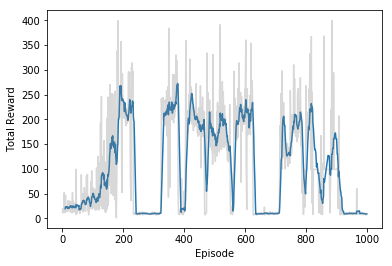

In [22]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(test_episodes):
        t = 0
        while t < test_max_steps:
            # env.render() 
            
            # Get action from Q-network
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            targetQ = sess.run(model.outputs, feed_dict)
            action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.